# The Basic Principles of the Rank-order Nearest Neighbor (NN) Phenotyping Workflow

Now Let's begin to think through the generalized workflow for our stomatal patterning phenotype (SPP) workflow. This can ultimately be broken up into 3 core phases of functions:

    (1) Assessment of Nearest Neighbor (NN) linkages between stomata based on rank-ordered distances
    (2) Generalization of NN associations for each genotype into Kernel Density Distributions (KDDs) which represent our SPPs.
    (3) Annotation and quantification of generalized patterning strategies represented by the SPPs either agnostically (i.e. feature extraction/comparison).


# Phase 1: Extracting Rank-order Nearest Neighbor (NN) Affiliations between stomatal coordinates

### Importing prerequisite libraries

Before we can begin this tutorial notebook we'll first need to load a few libraries into our environment that work alongside the pySPP library.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import datetime
import sys
import os
import cv2
import SPP

### Loading our files

Let's first begin by a subset from the data files derived from Xie's Mask R-CNN workflow. These correspond to one of two field trials, this data being collected during 2016. Let's begin by loading in 'maize_example_data.csv' as a dataframe and then resort them a bit based on their genotype, biological replicate (i.e. leaves from different plants), or technical replicates (i.e. Fields Of View or FOVs).

Let's go ahead and load in our 2016 data...

In [7]:
data2016=pd.read_csv('data/maize_example_data.csv')

data2016=data2016.loc[data2016['note']!='edge']

data2016=data2016.iloc[:,[0,1,2,3,8,9,11,10,7,15]]

Let's assess the first fiew rows of the 2016 example data to ensure everything loaded correctly...

In [10]:
data2016

,Genotype,Fieldplot,Replicate,FOV,x_center,y_center,length,width,stoma_area,length_width_ratio
0,Z019E0047,496,1,1,368.336329,359.488934,45.634884,22.203307,792.236328,2.055319
2,Z019E0047,496,1,1,409.847069,458.738320,41.338777,25.113106,811.767578,1.646104
3,Z019E0047,496,1,1,224.035644,246.915438,45.587822,26.944596,963.134766,1.691910
4,Z019E0047,496,1,1,328.098236,482.657926,38.108106,24.985123,745.849609,1.525232
5,Z019E0047,496,1,1,85.817563,67.056679,37.246189,32.136650,938.720703,1.158994
...,...,...,...,...,...,...,...,...,...,...
4696,Z019E0140,588,4,5,193.657808,441.428136,43.793588,19.123261,653.076172,2.290069
4697,Z019E0140,588,4,5,136.112672,129.804648,44.276342,21.928958,760.498047,2.019081
4698,Z019E0140,588,4,5,201.477701,378.073572,43.782237,19.872029,682.373047,2.203209
4699,Z019E0140,588,4,5,489.562530,206.913712,44.461114,18.741471,653.076172,2.372339


And now given that the average maize stomata is approximately ~50um from it's nearest neighbor we will go ahead and apply a filter to prune all points too close to the edge of our images in order to prune out these edge cases that could skew our results.

In [13]:
#This pixel to micron conversion and image size is specific to our groups optical tomographers, when generating your own images it is highly advised to confirm these values are as accurate as can be
px2um_scale=0.64
img_size=512

#Used to prune edge coordinates so that they are excluded from the list of origin coordinates used to generate the rank-order NN measures
offset=px2um_scale*50

data2016_pruned=data2016.iloc[np.where((data2016['x_center']>offset) & (data2016['x_center']<img_size-offset) & (data2016['y_center']>offset) & (data2016['y_center']<img_size-offset))[0],]

### Expected input dataframe format required by "stomata_rankedNN"

Before we get started we should probably first note a bit of data carpentry, to perform our rank-ordered nearest neighbors screen we will be handing the dataframes above to our library function, stomata_rankedNN(...). Although some of these columns are more critical to maintain than others generally the following format will be considered standard for this part of the workflow:

    (1) image_name - The name of the original image file that the X-Y coordinates correspond to, for following up on specific comparisons this is essential for cross referencing.
    (2) Project - The name of the project or experiment for which the data was generated.
    (3) Genotype - The genotype, be it an accession, a transgenic event, or even a segregating line resulting from some form of controlled cross.
    (4) Plots - Field positions or numbers in the event there were field or greenhouse trials with some form of standard replication to account for environmental variability.
    (5) Replicate - Biological replicates for a given genotype, in a given field plot, for a given project.
    (6) FOV - Technical replicates (usually different fields of view of the same sample) for a given genotype, in a given field plot, for a given project, on a given biological replicate.
    (7) x_center_um - The x coordinate locations of stomata flagged either by Mask-RCNN or Biodock in our image.
    (8) y_center_um - The y coordinate locations of stomata flagged either by Mask-RCNN or Biodock in our image.
    (9) length_um - The length of the major axis of stomata flagged either by Mask-RCNN or Biodock in our image.
    (10) width_um - The length of the minor axis of stomata flagged either by Mask-RCNN or Biodock in our image.
    (11) stoma_area_um.2 - The area of the mask used to flag individual stomata either by Mask-RCNN or Biodock in our image.
    (12) length_width_ratio - The ratio of values (9) Stomatal length and (10) Stomatal width which provides a cursory metric of stomatal shape.

Although columns 9-12 corresponding to stomatal size and shape attributes are not used in the nearest neighbor analysis it is often best to generate them alongside our patterning information so that we can circle back and cross reference this patterning data to the size and shape attributes. These column names will be expected by our function in order for it to properly assess neighbor relationships. 


We will start by generating nearest neighbor associations between our stomatal coordinates using one of the base functions of the MOM library, "stomata_rankedNN_biodock". This is the predecessor to the earlier "stomata_rankedNN" and although the names and likely merging of these functions is subject to change they both fundamentally operate on the same principle.  Stomatal coordinates are first extracted out of our dataframe so that we are effectively only comparing neighbors in a single image (the entails the bulk of the current genotype, rep, and FOV filters performed immediately below.  These coordinates are then fed into this function alongside an output dataframe to append the nearest neighbor values to the end of for however many ranks (generally we have found the first 5 to be the most informative) which can vary slightly based on the distance method used. 

There are presently two distance methods which can be applied for assigning these nearest neighbor relationships:

    Euclidean distances (E) are defined as, D.e = sqrt[(x.1...x.n - x.i)^2 + (y.1...y.n - y.i)^2]
    
    Manhattan distances (M) are defined as, D.m = |x.1...x.n - x.i| + |y.1...y.n - y.i|
    
It should be noted that as OT images are generally taken with the cell files directly horizontal to the x-axis the stomatal files within our coordinates tend to migrate along the cardinal directions.  Given that Manhattan distances tend to penalize diagonal movement we typically use this method for scoring grass stomatal patterning as it's anticipated to help boost the signal that is already present and make it even more recognizable.

We will now run the following loop below which will iterate across the genotypes in data2016 and estimate these 1-5 rank-order NN relationships for each stomata then append it to our new dataframe to house these measures 'NNSeries'. (Warning: This step will take some time!)

In [16]:
rankedNNs=pd.DataFrame(columns=['Genotype', 'Fieldplot', 'Replicate', 'FOV', 'Current_SC', 'NN_rank', 'NN_dist', 'Origin_X', 'Origin_Y', 'NN_x', 'NN_y', 'NN_dist_xdiff', 'NN_dist_ydiff'])
rankedNNs

,Genotype,Fieldplot,Replicate,FOV,Current_SC,NN_rank,NN_dist,Origin_X,Origin_Y,NN_x,NN_y,NN_dist_xdiff,NN_dist_ydiff


Now let's have a quick look at one of the core functions we'll be using to populate rankedNNs, the stomata_rankedNN(...) function.

In [19]:
help(SPP.stomata_rankedNN)

Help on function stomata_rankedNN in module SPP:

stomata_rankedNN(sample_data, distance='M', rankno=5)



### The stomata_rankedNN(...) function

#### Input Arguments: 
    
    (1) sample_data - (Required input!) A data frame which follows the formatting of the data2016 dataframe shown above
    (2) distance - (Defaults to 'M') The distance method used to assess rank-ordered neighbor relationships between stomatal coordinates, 'M' or Manhattan distance typically works best on grasses due to their file system, 'E' or Euclidean is also available as an option however.
    (3) rankno - (Defaults to 5) The number of rank-order nearest neighbors to identify for each origin coordinate.

#### Outputs: 

    (1) rankedNNs - The rank-order nearest neighbors for each individual stomata contained with the image(s). 
    
Now that we have a blank dataframe in the correct format we can populate it with our rank-order nearest neighbor data using the loop below.

In [22]:
SC_data2016=data2016_pruned.rename(columns={'x_center': 'x_center_um', 'y_center': 'y_center_um', 'length': 'length_um', 'width': 'width_um', 'stoma_area': 'stoma_area_um.2'})

SC_data2016['x_center_um']=SC_data2016['x_center_um']*px2um_scale
SC_data2016['y_center_um']=SC_data2016['y_center_um']*px2um_scale
SC_data2016['length_um']=SC_data2016['length_um']*px2um_scale
SC_data2016['width_um']=SC_data2016['width_um']*px2um_scale
SC_data2016['stoma_area_um.2']=SC_data2016['stoma_area_um.2']*np.square(px2um_scale)

##########################################################
# Scan and assign Nearest Neighbor associations for 2016 #
##########################################################

start_time = datetime.datetime.now()

rankedNNs_2016=pd.DataFrame(columns=['Genotype', 'Fieldplot', 'Replicate', 'FOV', 'Current_SC', 'NN_rank', 'NN_dist', 'Origin_X', 'Origin_Y', 'NN_x', 'NN_y', 'NN_dist_xdiff', 'NN_dist_ydiff'])

genos=np.unique(data2016_pruned['Genotype'])

for cur_geno in genos:
        
    SD_counts=[]
    
    GenotypeNNs=pd.DataFrame(columns=['Genotype', 'Fieldplot', 'Replicate', 'FOV', 'Current_SC', 'NN_rank', 'NN_dist', 'Origin_X', 'Origin_Y', 'NN_x', 'NN_y', 'NN_dist_xdiff', 'NN_dist_ydiff'])
    
    g_data=data2016_pruned.loc[data2016_pruned['Genotype']==cur_geno]
    
    flds=np.unique(data2016_pruned[data2016_pruned['Genotype']==cur_geno]['Fieldplot'])    
    for fld in flds:

        reps=np.unique(data2016_pruned[(data2016_pruned['Genotype']==cur_geno) & (data2016_pruned['Fieldplot']==fld)]['Replicate'])    
        for rep in reps:

            fovs=np.unique(data2016_pruned[(data2016_pruned['Genotype']==cur_geno) & (data2016_pruned['Fieldplot']==fld) & (data2016_pruned['Replicate']==rep)]['FOV'])   
            for fov in fovs:

                sample_data=data2016_pruned.loc[(data2016_pruned['Genotype']==cur_geno) & (data2016_pruned['Fieldplot']==fld) & (data2016_pruned['Replicate']==rep) & (data2016_pruned['FOV']==fov)]
                SD_counts.append(len(sample_data))

                curNNs=SPP.stomata_rankedNN(sample_data,  'M', 5)

                GenotypeNNs = pd.concat([GenotypeNNs, curNNs], axis=0, ignore_index=True)
                
                rankedNNs_2016 = pd.concat([rankedNNs_2016, curNNs], axis=0, ignore_index=True)
        
    print('Completed Genotype ', cur_geno, '...')
    print('    (Avg. SD ('+str(len(SD_counts))+' images) = '+str(np.round(np.mean(SD_counts),2))+' +/- '+str(np.round(2*np.std(SD_counts),2))+')')


stop_time = datetime.datetime.now()
elapsed_time = stop_time - start_time

elapsed_time_seconds = elapsed_time.total_seconds()

print("Elapsed time:", elapsed_time_seconds, "seconds")


Completed Genotype  Z019E0047 ...
    (Avg. SD (20 images) = 51.8 +/- 16.93)
Completed Genotype  Z019E0052 ...
    (Avg. SD (15 images) = 63.8 +/- 23.39)
Completed Genotype  Z019E0106 ...
    (Avg. SD (20 images) = 47.7 +/- 16.27)
Completed Genotype  Z019E0140 ...
    (Avg. SD (20 images) = 26.3 +/- 8.86)
Elapsed time: 7.423224 seconds


After having successfully saved this data we can now move on to the second tutorial which begins to expand further on generating and exploring the stomatal patterning phenotypes (SPPs) that quantify spatial patterning behavior within our data which we can generate as kernel density distributions (KDDs).

# Phase 2: Generating Kernel Densities of Nearest Neighbors to represent our stomatal patterning phenotype (SPP)

We've gone ahead and generated our initial data files we'll need to....



Let's first begin by generating our Kernel Density Distributions which we refer to as 'Z' of each replicate (i.e., averaging across technical replicates or fields of view).  This is first accomplished by the stomata_KDDs(...) function which we use an 'avgrank' for that calculates the average 'Z' across the first 5 rank orders to generate our kernel density heatmap. We assign the output of this function to 'RepZ'.

First let's begin by discussing the arguments necessary to run SPP.stomata_KDDs(...), let's first run the help and see what these are:
  

In [24]:
help(SPP.stomata_KDDs)

Help on function stomata_KDDs in module SPP:

stomata_KDDs(NNSeries, xbound=100, ybound=100, ori_len=20, ori_wid=10, rankno=5, rankmethod='avgrank', plotting=False, plotname='Plotname')



### The stomata_KDDs(...) Function

As we can see above there appear to be 9 arguments needed by stomata_KDDs(...), the role of these arguments are as follows:

#### Input Arguments:

    (1) NNSeries - (Required input!) A rank-order nearest neighbor dataframe generated from stomata_rankedNN(...).
    (2) xbound - (Defaults to 100)
    (3) ybound - (Defaults to 100)
    (4) ori_len - (Defaults to 20) The average length of the origin objects (i.e., stomatal complex lengths) being assessed, used for plotting.
    (5) ori_wid - (Defaults to 10) The average width of the origin objects (i.e., stomatal complex widths) being assessed, used for plotting. 
    (6) rankno -  (Defaults to 5) The rank number to used for generating KDDs, either the average among ranks up to this number or as this current specific number by itself. The context of how rankno is used is governed by the subsequent argument, rankmethod.
    (7) rankmethod - (Defaults to 'avgrank') Further specifies the behavior of how the rankno integer will be used. If assigned to 'avgrank' a KDD will be generated of a average from the 1st - rankno sequence of rank-orders.  If assigned to 'currank' a KDD will be generated corresponding to the current rank-order number presented in rankno.
    (8) plotting - (Defaults to False) Specifies whether to output a plotting result of the current KDD, when using to generate batch data particularly for large populations it is advised to keep this set to False.
    (9) plotname - (Defaults to 'Plotname') If it's default status is not retained, the plot will be saved as a figure using this plotname argument as the filename to save as.
  
#### Outputs:
    
    (1) Z - A 2-dimensional kernel density distribution matrix representing the spatial probability that corresponds to the rank-order nearest neighbor distances from the origin.
    
These arguments are used to generate a Kernel Density Distribution (KDD), or essentially a probability surface corresponding to the frequency of having a nearest neighbor stomata at a given X-Y window grid, or kernel, position. Given that both the X and Y dimensions are retained for spatial measurements we invoke a third axis 'Z' typically when referring to this surface of probabilities and the objects stomata_KDDs(...) outputs are saved to typically reflect this within the scope of this demonstration.

Let's do a test run of a single biological replicate to get a sense of what these spatial probability outputs look like, we'll set plotting to True in this case so we can see our KDD alongside the original nearest neighbor vertices normalized to their distance to their respective origin to get a sense of this function.

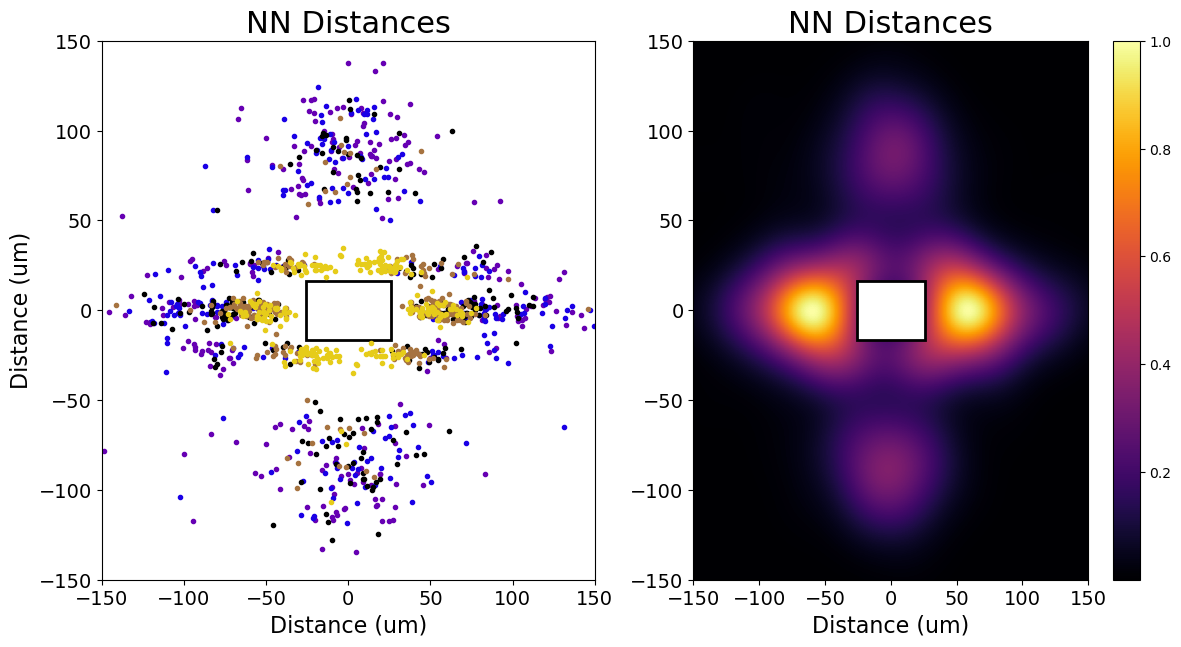

In [28]:
ranks=5
xbound=150
ybound=150

cur_geno='Z019E0047'
fld=496
rep=1

SD_counts=[]
SC_lengths=[]
SC_widths=[]
SC_areas=[]
SC_lwratios=[]

AccNNs=rankedNNs_2016[rankedNNs_2016['Genotype']==cur_geno]

fovs=np.unique(AccNNs['FOV'])
for fov in fovs:

    img_coord_index=np.where((SC_data2016['Genotype']==cur_geno) & (SC_data2016['Fieldplot']==fld) & (SC_data2016['Replicate']==rep) & (SC_data2016['FOV']==fov))
    Repdata=SC_data2016.iloc[img_coord_index[0]]

    SD_counts.append(Repdata.shape[0]*1.25)
    SC_lengths.append(np.round(np.mean(Repdata['length_um']),2))
    SC_widths.append(np.round(np.mean(Repdata['width_um']),2))
    SC_areas.append(np.round(np.mean(Repdata['stoma_area_um.2']),2))
    SC_lwratios.append(np.round(np.mean(Repdata['length_width_ratio']),2))

SD_counts_mu=np.round(np.mean(SD_counts),2)
SC_lengths_mu=np.round(np.mean(SC_lengths),2)
SC_widths_mu=np.round(np.mean(SC_widths),2)
SC_areas_mu=np.round(np.mean(SC_areas),2)
SC_lwratios_mu=np.round(np.mean(SC_lwratios),2)

RepNNs=AccNNs.iloc[np.where((AccNNs['Fieldplot']==fld) & (AccNNs['Replicate']==rep))[0],:]

RepZ=SPP.stomata_KDDs(RepNNs, xbound, ybound, SC_lengths_mu, SC_widths_mu, ranks, 'avgrank', plotting=True)

Above we can see the original ranked nearest neighbor vertices in the left 'NN Distances' plot and on the right we can see the corresponding KDD from this initial data.  Moreover, we passed the probability surface we're seeing in our KDDs to the 'RepZ' object which allows use to leverage this matrix for further downstream analyses. 

While we're at this step let's also explore the rankmethod behavior mentioned above by changing the rankmethod argument to 'currank' and focusing on the KDD probability information within just the first rank-order:

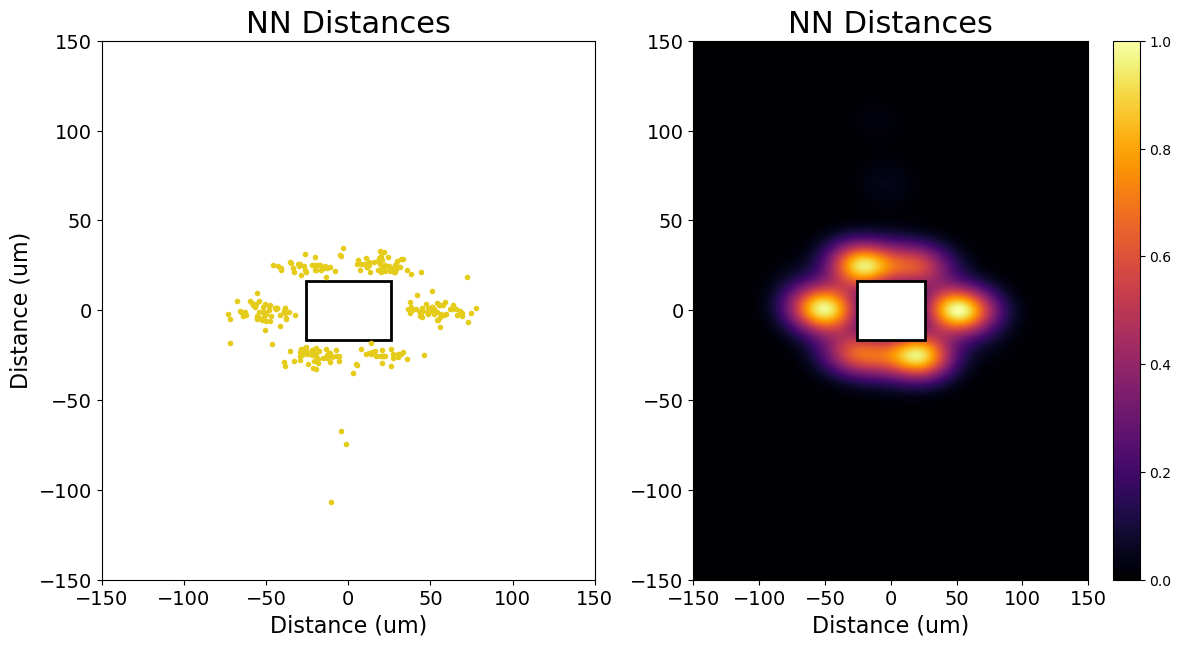

In [30]:
ranks=1

RepZ1=SPP.stomata_KDDs(RepNNs, xbound, ybound, SC_lengths_mu, SC_widths_mu, ranks, 'currank', plotting=True)

We can see that the in-file peaks typical of grasses are still strongly represented immediately to the right and left of our origin box. We can see however that there are more than just these two hotspots which appear around our origin with four additional hotspots appearing in the off-diagonal from our origin.  Although there clearly is a preference for maintaining a linear file system given the 2 right and left flanking in-file peaks, the presence of these additional off-diagonal peaks suggests that this replicate, possibly even the accession overall has a tendency for generating diffuse files (i.e., two stomatal files sitting immediately alongside eachother generating a zig-zag like arrange of neighboring stomatal between these two files. Although we'll primarily focus on the average KDD signal information it is still worth noting that there are additional dimensions of spatial information such as these diffuse files that can be explored within this data. 

Additionally, we can try to smooth out the lopsided skew among the 4 diffuse-file hotspots we're seeing using a supplementary function, stomata_KDD_rorshach(...) which as it's name suggests folds the probability values across the four quadrants with respect to the origin over one another to creat a more homogeneous pattern:


Help on function stomata_KDD_rorshach in module SPP:

stomata_KDD_rorshach(Z, plotting=False)



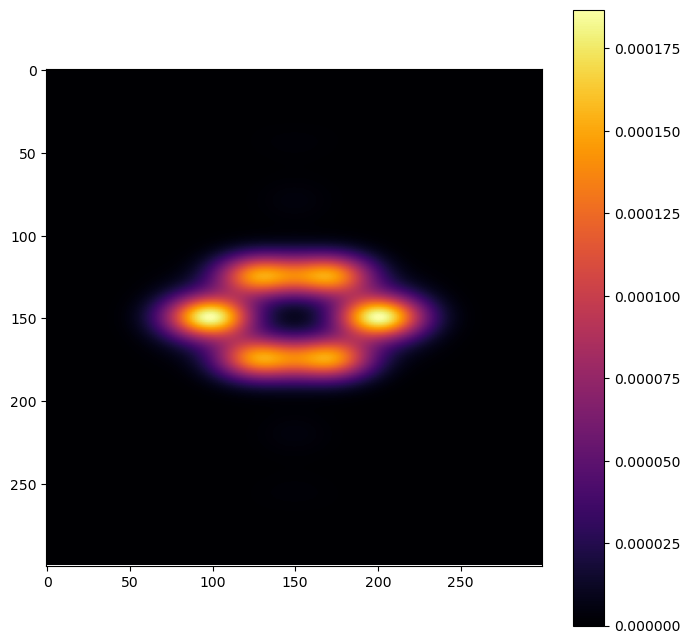

In [34]:
help(SPP.stomata_KDD_rorshach)

RepZ1norm=SPP.stomata_KDD_rorshach(RepZ1, True)

Let's return back to our original task at hand. Now that we have 'RepZ' from our stomata_KDDs(...) function, one of the first steps we can take is to extract the flattened probabilities from this surface as two orthogonal histograms. The function stomata_KDD_hist(...) performs this role of flattening our KDDs into horizontal and vertical density distributions.  Let's begin as we did above by looking at the help for this function and see what arguments it requires:

In [37]:
help(SPP.stomata_KDD_hist)

Help on function stomata_KDD_hist in module SPP:

stomata_KDD_hist(NNSeries, Z, xbound, ybound, ori_len=20, ori_wid=10, rankno=5, plotting=False, plotname='Plotname', horimax=None, vertmax=None)



### The stomata_KDD_hist(...) Function

As we can see above there are 11 arguments needed by stomata_KDD_hist(...) several of which are shared with the previous stomata_KDDs(...) function. The role of these arguments are as follows:

#### Input Arguments:

    (1) NNSeries - (Required input!) A rank-order nearest neighbor dataframe generated from stomata_rankedNN(...).
    (2) Z - (Required input!) The Z probability surface KDD generated from stomata_KDDs(...).
    (3) xbound - (Defaults to 100)
    (4) ybound - (Defaults to 100)
    (5) ori_len - (Defaults to 20) The average length of the origin objects (i.e., stomatal complex lengths) being assessed, used for plotting.
    (6) ori_wid - (Defaults to 10) The average width of the origin objects (i.e., stomatal complex widths) being assessed, used for plotting. 
    (7) rankno -  (Defaults to 5) The rank number to used for generating KDDs, specifically the average among ranks up to this number, this function lacks a 'currank' rankmethod behavior akin to what was seen above in stomata_KDDs(...).  
    (8) plotting - (Defaults to False) Specifies whether to output a plotting result of the current KDD, when using to generate batch data particularly for large populations it is advised to keep this set to False.
    (9) plotname - (Defaults to 'Plotname') If it's default status is not retained, the plot will be saved as a figure using this plotname argument as the filename to save as.
    (10) horimax - (Defaults to None) Specifies the ceiling when plotting the horizontal density distribution, this can be useful when comparing multiple flattened histogram plots as the magnitude can be normalized to a global ceiling.
    (11) vertmax - (Defaults to None) Specifies the ceiling when plotting the vertical density distribution, this can be useful when comparing multiple flattened histogram plots as the magnitude can be normalized to a global ceiling.

#### Outputs:
    
    (1) hp - A horizontally flattened 1-dimensional probability density distribution corresponding to the 2D KDD object, 'Z' which was used as an input.
    (2) vp - A vertically flattened 1-dimensional probability density distribution corresponding to the 2D KDD object, 'Z' which was used as an input.
    
Our previous function stomata_KDDs(...) produced a probability surface and a plot which is essentially a visualization of this same Z surface.  By contrast, stomata_KDD_hist(...) produces two vectors which correspond to the shape of the histogram densities along each horizontal probability (i.e., hp) and vertical probability (i.e., vp) distributions.  As with our previous function we also have the capacity to plot these density functions superimposed alongside their original KDD. Let's continue with our example of a single replicate from above and see what these density distributions look like using 'RepZ' as our input: 


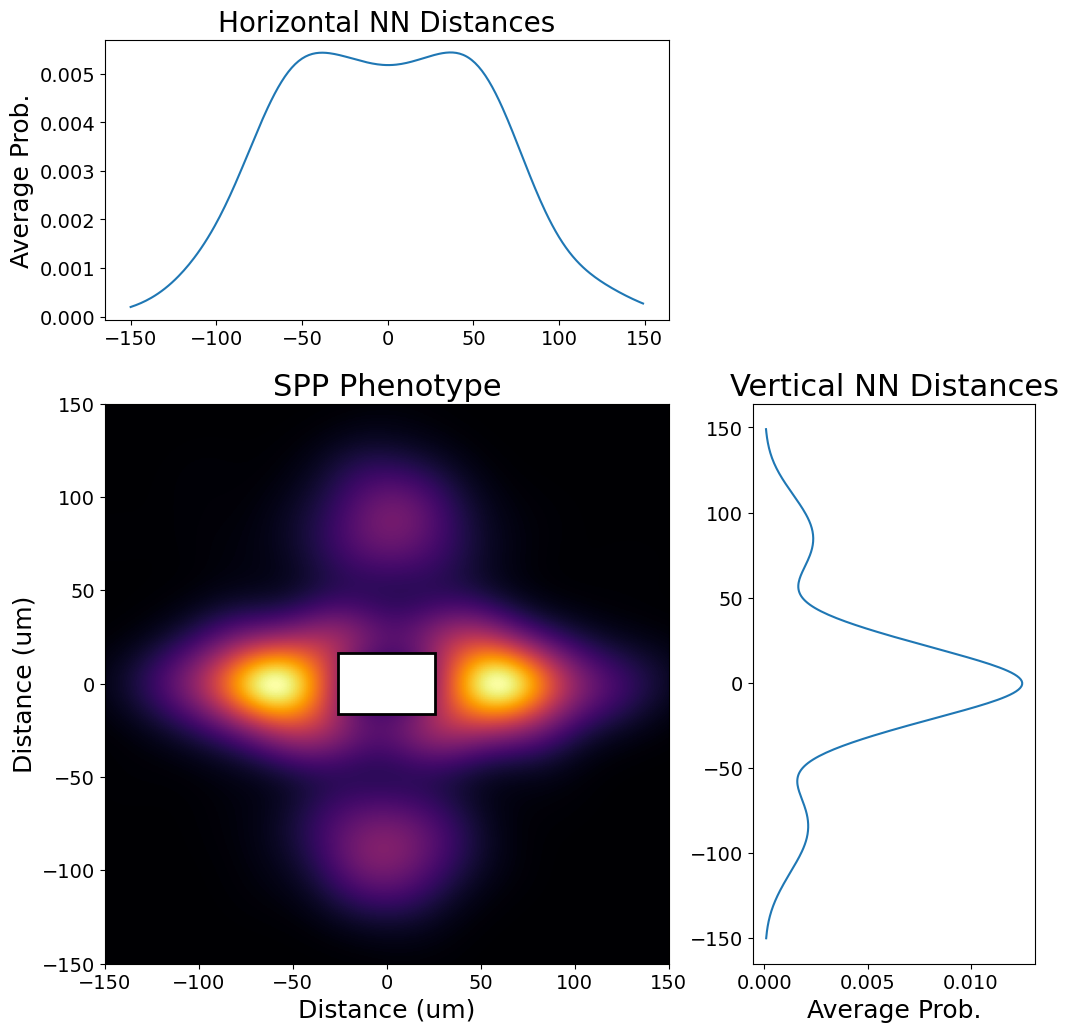

In [40]:
hp, vp = SPP.stomata_KDD_hist(RepNNs, RepZ, xbound, ybound, SC_lengths_mu, SC_widths_mu, ranks, plotting=True)

Now that we have a sense of how this code works with each sample we can nest this same logic within a loop in order to iterate across all samples, easily pooling our inventory of KDDs into a single object 'Z_series' that represents our populations 'avgrank' pattern. 

In [43]:
project='Maize_2016_Example_'

geno_series=[]
field_series=[]
rep_series=[]

SD_series=[]
SClen_series=[]
SCwid_series=[]
SCarea_series=[]
SClwr_series=[]

hp_series=[]
vp_series=[]

Z_series=[]

genos=np.unique(rankedNNs_2016['Genotype'])

for cur_geno in genos:

    SD_counts=[]
    SC_lengths=[]
    SC_widths=[]
    SC_areas=[]
    SC_lwratios=[]


    flds=np.unique(rankedNNs_2016[rankedNNs_2016['Genotype']==cur_geno]['Fieldplot'])
    for fld in flds:
        
        reps=np.unique(rankedNNs_2016[(rankedNNs_2016['Genotype']==cur_geno) & (rankedNNs_2016['Fieldplot']==fld)]['Replicate'])   
        for rep in reps:
            
            fovs=np.unique(rankedNNs_2016[(rankedNNs_2016['Genotype']==cur_geno) & (rankedNNs_2016['Fieldplot']==fld) & (rankedNNs_2016['Replicate']==rep)]['FOV'])   
            for fov in fovs:
                
                Repdata=SC_data2016.iloc[np.where((SC_data2016['Genotype']==cur_geno) & (SC_data2016['Fieldplot']==fld) & (SC_data2016['Replicate']==rep) & (SC_data2016['FOV']==fov))[0]]

                SD_counts.append(Repdata.shape[0]*1.25)
                SC_lengths.append(np.round(np.mean(Repdata['length_um']),2))
                SC_widths.append(np.round(np.mean(Repdata['width_um']),2))
                SC_areas.append(np.round(np.mean(Repdata['stoma_area_um.2']),2))
                SC_lwratios.append(np.round(np.mean(Repdata['length_width_ratio']),2))
                
            print(cur_geno, fld, rep)
            
            SD_counts_mu=np.round(np.mean(SD_counts),2)
            SC_lengths_mu=np.round(np.mean(SC_lengths),2)
            SC_widths_mu=np.round(np.mean(SC_widths),2)
            SC_areas_mu=np.round(np.mean(SC_areas),2)
            SC_lwratios_mu=np.round(np.mean(SC_lwratios),2)
            
            RepNNs=rankedNNs_2016[(rankedNNs_2016['Genotype']==cur_geno) & (rankedNNs_2016['Fieldplot']==fld) & (rankedNNs_2016['Replicate']==rep)]

            RepZ=SPP.stomata_KDDs(RepNNs, xbound, ybound, SC_lengths_mu, SC_widths_mu, ranks, 'avgrank', False)

            hp, vp = SPP.stomata_KDD_hist(RepNNs, RepZ, xbound, ybound, SC_lengths_mu, SC_widths_mu, ranks, False)

            geno_series.append(cur_geno)
            field_series.append(fld)
            rep_series.append(rep)
            SD_series.append(SD_counts_mu)
            SClen_series.append(SC_lengths_mu)
            SCwid_series.append(SC_widths_mu)
            SCarea_series.append(SC_areas_mu)
            SClwr_series.append(SC_lwratios_mu)

            Z_series.append(RepZ)
            hp_series.append(hp)
            vp_series.append(vp)

t_hp_series=np.transpose(np.array(hp_series))
t_vp_series=np.transpose(np.array(vp_series))

geno_series=np.array(np.array(geno_series))
field_series=np.array(np.array(field_series))
rep_series=np.array(np.array(rep_series))
SD_series=np.array(np.array(SD_series))
SClen_series=np.array(np.array(SClen_series))
SCwid_series=np.array(np.array(SCwid_series))
SCarea_series=np.array(np.array(SCarea_series))
SClwr_series=np.array(np.array(SClwr_series))


Z019E0047 496 1
Z019E0047 496 2
Z019E0047 496 3
Z019E0047 496 4
Z019E0052 501 2
Z019E0052 501 3
Z019E0052 501 4
Z019E0106 554 1
Z019E0106 554 2
Z019E0106 554 3
Z019E0106 554 4
Z019E0140 588 1
Z019E0140 588 2
Z019E0140 588 3
Z019E0140 588 4


Let's remember our rank specific KDD from above though where we could see file system patterning information contained within just the first rank.  There are times where there may be interesting features in specific rank-orders, however, and the workflow above may not allow for this information to be easily captured and stored. Fortunately, stomata_KDDs(...) is designed with a fairly flexible behavior to address this.  Above we ran this function with the argument 'avgranks' when ranks was set to 5 (our usual cutoff point for this analysis), so essentially we are generating a single KDD that takes the average between 1 through ranks, or in our case 1 through 5.  We can modify this behavior by using 'currank' instead of 'avgrank' at which point only the current rank number will be used to generate a Z probability surface.  Below we see a slightly modified version of the previous loop where we include this behavior.  

In [45]:
project='2016_'

ranks=5
xbound=150
ybound=150

#Ranked KDD attributes
Z1_series=[]
Z2_series=[]
Z3_series=[]
Z4_series=[]
Z5_series=[]
Z_series=[]

#Flattened (horizontal/vertical) KDD attributes
hp_series=[]
vp_series=[]

for cur_geno in genos: 
    
    flds=np.unique(rankedNNs_2016[rankedNNs_2016['Genotype']==cur_geno]['Fieldplot'])
    for fld in flds:
        
        reps=np.unique(rankedNNs_2016[(rankedNNs_2016['Genotype']==cur_geno) & (rankedNNs_2016['Fieldplot']==fld)]['Replicate'])   
        for rep in reps:
            
            print(cur_geno, fld, rep)
            
            RepNNs=rankedNNs_2016[(rankedNNs_2016['Genotype']==cur_geno) & (rankedNNs_2016['Fieldplot']==fld) & (rankedNNs_2016['Replicate']==rep)]

            SCL_mu=SClen_series[(geno_series==cur_geno) & (rep_series==rep)][0]
            SCW_mu=SCwid_series[(geno_series==cur_geno) & (rep_series==rep)][0]

            RepZ1=SPP.stomata_KDDs(RepNNs, xbound, ybound, SCL_mu, SCW_mu, 1, 'currank', False)
            RepZ2=SPP.stomata_KDDs(RepNNs, xbound, ybound, SCL_mu, SCW_mu, 2, 'currank', False)
            RepZ3=SPP.stomata_KDDs(RepNNs, xbound, ybound, SCL_mu, SCW_mu, 3, 'currank', False)
            RepZ4=SPP.stomata_KDDs(RepNNs, xbound, ybound, SCL_mu, SCW_mu, 4, 'currank', False)
            RepZ5=SPP.stomata_KDDs(RepNNs, xbound, ybound, SCL_mu, SCW_mu, 5, 'currank', False)  
            RepZ=SPP.stomata_KDDs(RepNNs, xbound, ybound, SCL_mu, SCW_mu, ranks, 'avgrank', False)

            hp, vp = SPP.stomata_KDD_hist(RepNNs, RepZ, xbound, ybound, SCL_mu, SCW_mu, ranks, False)

            #Ranked KDD attributes
            Z1_series.append(RepZ1)
            Z2_series.append(RepZ2)
            Z3_series.append(RepZ3)
            Z4_series.append(RepZ4)
            Z5_series.append(RepZ5)
            Z_series.append(RepZ)

            #Flattened (horizontal/vertical) KDD attributes
            hp_series.append(hp)
            vp_series.append(vp)

Z019E0047 496 1
Z019E0047 496 2
Z019E0047 496 3
Z019E0047 496 4
Z019E0052 501 2
Z019E0052 501 3
Z019E0052 501 4
Z019E0106 554 1
Z019E0106 554 2
Z019E0106 554 3
Z019E0106 554 4
Z019E0140 588 1
Z019E0140 588 2
Z019E0140 588 3
Z019E0140 588 4


Now that we have successfully run through the workflow which can generate our stomatal patterning phenotype (SPP) from rank-order nearest neighbors we can begin to think about key measurements, or traits, which can readily be extracted as used for downstream analysis.  This brings us to the final phase of this demonstration. 

# Phase 3: Extracting the Core Patterning Traits from the Stomatal Patterning Phenotypes

These Z probability surfaces are quite data rich and allow us to readily pull out a series of traits which we can use for downstream analyses. Cell size measures are already captured within the AI mask annotation workflows, however, there are two unique layers of data we can leverage to produce new traits within this analysis which leverage the fact that 

In [48]:
help(SPP.stomata_KDD_deriv_anno)

Help on function stomata_KDD_deriv_anno in module SPP:

stomata_KDD_deriv_anno(vp, Z, xbound, ybound, ori_len=20, ori_wid=10, plotting=False, plotname='Plotname')



### The stomata_KDD_deriv_anno(...) function

#### Input Arguments:
    (1) vp - (Required input!) A vertically flattened 1-dimensional probability density distribution generated from stomata_KDD_hist(...) function.
    (2) Z -  (Required input!) The Z probability surface KDD generated from stomata_KDDs(...).
    (3) xbound -  (Defaults to 100)
    (4) ybound -  (Defaults to 100)
    (5) ori_len - (Defaults to 20) The average length of the origin objects (i.e., stomatal complex lengths) being assessed, used for plotting.
    (6) ori_wid - (Defaults to 10) The average widths of the origin objects (i.e., stomatal complex widths) being assessed, used for plotting.
    (7) plotting - (Defaults to False) Specifies whether to output a plotting result of the current KDD, when using to generate batch data particularly for large populations it is advised to keep this set to False.
    (8) plotname - (Defaults to 'Plotname') If it's default status is not retained, the plot will be saved as a figure using this plotname argument as the filename to save as.

#### Outputs:

    (1) origin_trench_dist - The second-derivative annotation estimated distance between the KDD trench and the origin.
    (2) origin_peak_dist - The second-derivative annotation estimated distance between the KDD side-file peak and the origin.
    (3) trenchprob_FC - The fold-change difference between the probability at the in-file peak position and the trench position.
    (4) Peaksprob_FC - The fold-change difference between the probability at the in-file peak position and the side-file peak position.
    
Now let's try to run this second-derivative annotation function on our KDDs and see what traits we're readily able to extract from our SPP heatmap:

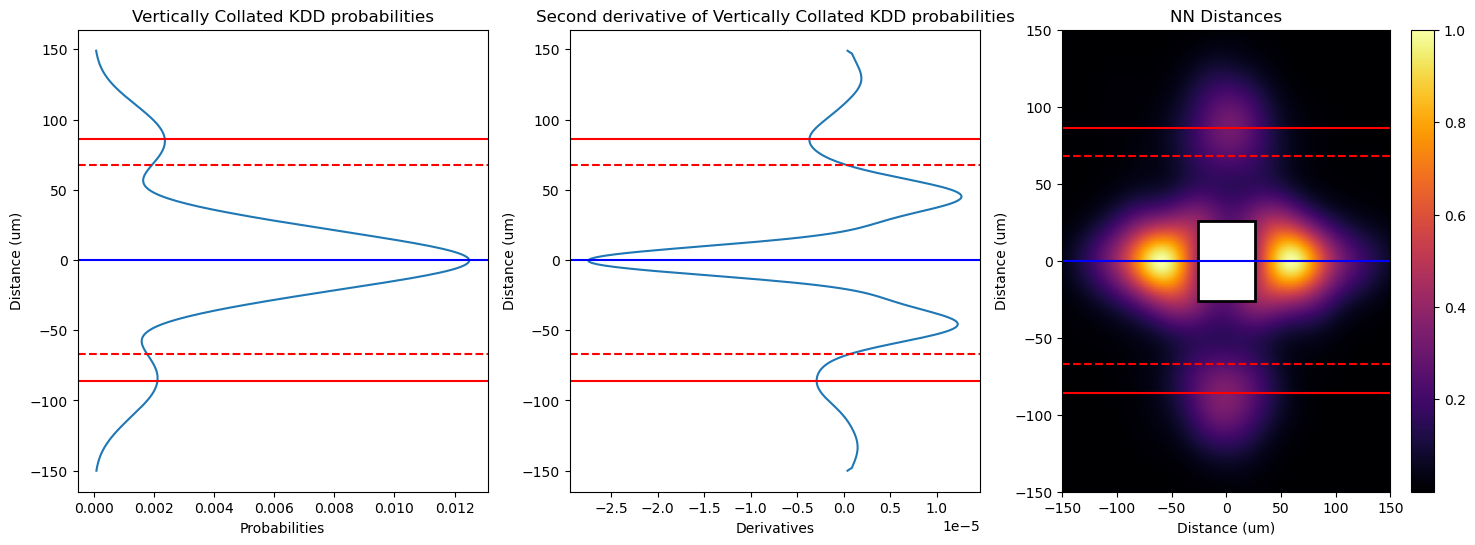



   Distance Traits:

Trench distance from origin (um) = 67.5
Side-file peak distance from origin (um) = 86.0


   Fold-change Traits:

Diffuse-file:origin probability fold-change difference = -0.391
Trench:origin probability fold-change difference = -0.851
Side-file peak:origin probability fold-change difference = -0.821


   Probability Traits:

The In-file probability = 0.012
The Diffuse-file probability = 0.011
The Trench probability = 0.002
The Side-file peak probability = 0.002


In [50]:
cur_geno='Z019E0047'
fld=496
rep=1

AccNNs=rankedNNs_2016[rankedNNs_2016['Genotype']==cur_geno]
RepNNs=AccNNs.iloc[np.where((AccNNs['Fieldplot']==fld) & (AccNNs['Replicate']==rep))[0],:]

RepZ=np.array(Z_series)[(geno_series=='Z019E0047') & (field_series==fld) & (rep_series==rep)][0]
RepZ1=np.array(Z1_series)[(geno_series=='Z019E0047') & (field_series==fld) & (rep_series==rep)][0]

SCL_mu=np.array(SClen_series)[np.where((geno_series=='Z019E0047') & (field_series==fld) & (rep_series==rep))[0]]
SCW_mu=np.array(SClen_series)[np.where((geno_series=='Z019E0047') & (field_series==fld) & (rep_series==rep))[0]]

RepHP, RepVP = SPP.stomata_KDD_hist(RepNNs, RepZ, xbound, ybound, SCL_mu, SCW_mu, ranks, False)
RepHP1, RepVP1 = SPP.stomata_KDD_hist(RepNNs, RepZ1, xbound, ybound, SCL_mu, SCW_mu, ranks, False)

origin_trench_dist, origin_peak_dist, trenchprob_FC, Peaksprob_FC = SPP.stomata_KDD_deriv_anno(RepVP, RepZ, xbound, ybound, SCL_mu, SCW_mu, True)


IF_prob=RepVP[int((len(RepVP)/2))]
DF_prob=(RepVP[int((len(RepVP)/2)-(SCW_mu/2))]+RepVP[int((len(RepVP)/2)+(SCW_mu/2))])/2
Tr_prob=(RepVP[int((len(RepVP)/2)-origin_trench_dist)]+RepVP[int((len(RepVP)/2)+origin_trench_dist)])/2
SP_prob=(RepVP[int((len(RepVP)/2)-origin_peak_dist)]+RepVP[int((len(RepVP)/2)+origin_peak_dist)])/2

Diffuseprob_FC=(DF_prob-RepVP1[int((len(RepVP1)/2))])/RepVP1[int((len(RepVP1)/2))]

print('\n\n   Distance Traits:\n')
print('Trench distance from origin (um) = '+str(origin_trench_dist))
print('Side-file peak distance from origin (um) = '+str(origin_peak_dist))

print('\n\n   Fold-change Traits:\n')
print('Diffuse-file:origin probability fold-change difference = '+str(np.round(Diffuseprob_FC,3)))
print('Trench:origin probability fold-change difference = '+str(trenchprob_FC))
print('Side-file peak:origin probability fold-change difference = '+str(Peaksprob_FC))

print('\n\n   Probability Traits:\n')
print('The In-file probability = '+str(np.round(IF_prob,3)))
print('The Diffuse-file probability = '+str(np.round(DF_prob,3)))
print('The Trench probability = '+str(np.round(Tr_prob,3)))
print('The Side-file peak probability = '+str(np.round(SP_prob,3)))

Quite a bit happened in that code above but this is ultimately how we generate the majority of the measures we use as traits for downstream analysis!  As we scan through the plots generated by stomata_KDD_deriv_anno(...) we see three panels, left panel represents our vertically flattened density distribution and our right panel is clearly our KDD heatmap, the middle panel is unique compared to what we've seen so far.  The trimodal pattern of one primary in-file peak and two minor flanking side-file peaks was so consistent across this population that it allowed for the generation of this function which simply uses a bit of calculus to generate the second derivative of our vertically flattened density distribution.  In comparing the inflections of the flattened density distributions and their second derivatives we have a means to rapidly tag three regions of this space that are of biological interest. 

    (1) The solid blue line clearly represents our in-file peak and by definition this typically should be found at either 0 along the y-axis or the local maxima within the 'vp' object.
    (2) The solid red lines tag the approximate maxima position of the two minor, Side-file, peaks which capture the files neighboring our origin stomata.
    (3) The dotted red lines tag the approximate position of the trench in relation to the in-file and side-file peaks. This measure is known to be a bit greedy in it's current deployment and favors being a bit closer to it's corresponding side-file peak positions.
    
    
Once we have this positional information we can go either use these positional measures direction or use them to extract probability signal information and key locations within our KDD. The distance and fold-change measures are somewhat self-explanatory in this regard and leverage the positional information we just generated to pass these values to the user as outputs. Once we have the trench and side-file peak positions in particular though we can revisit our 'vp' object and use these indices to pull out the local probability where these regions have been tagged by our annotation workflow.  The in-file probabilty can typically be pulled from the midposition within our 'vp' object. If we are interested in specific rank-order layers as we noted with our diffuse files above we can also generate flattened density distributions of a single rank-order and perform indexing ourselves (usually diffuse-files are the the immediate file over so stomatal complex width serves as a reasonable positional index to extract this probability.  

##### NOTE: The stomata_KDD_deriv_anno(...) function was largely developed assuming the trimodal pattern typical of the 1st - 5th rank averages was present. This workflow and the functions are designed to be flexible but various patterning behaviors have been noted within distinct rank-orders such as the diffuse-files that automated annotations do not exist for quite yet.  Take care not to use stomata_KDD_deriv_anno(...) outside of it's intended context as there are no guarantees that you'll get something meaningful once its core assumptions aren't being met!   

Now that we have a sense of how we can generate trait annotations with this test case let's see how we can integrate this into a loop so that we can run it across our example data:

In [55]:
IF_prob_series=[]
TF_prob_series=[]
Tr_prob_series=[]
SP_prob_series=[]
Tdist_series=[]
Pdist_series=[]
TFFC_series=[]
TrFC_series=[]
SPFC_series=[]

ori_len=20
ori_wid=10

for i in np.arange(0,len(Z1_series)):

    #Call current samples KDD Z matrices
    Z1=Z1_series[i]/np.max(Z1_series[i])
    Z2=Z2_series[i]/np.max(Z2_series[i])
    Z3=Z3_series[i]/np.max(Z3_series[i])
    Z4=Z4_series[i]/np.max(Z4_series[i])
    Z5=Z5_series[i]/np.max(Z5_series[i])
    Z=np.mean([Z1, Z2, Z3, Z4, Z5], axis=0)

    #Call flattened KDDs to extract probabilities from
    vp=vp_series[i]    
    vp1=np.zeros(Z1.shape[1])

    origin_trench_dist, origin_peak_dist, trenchprob_FC, Peaksprob_FC = SPP.stomata_KDD_deriv_anno(vp, Z, xbound, ybound, SClen_series[i], SCwid_series[i], False)

    for j in range(0,Z1.shape[0]):
        vp1=vp1+Z1[:,j]

    vp1=vp1/np.sum(vp1)

    IF_prob=vp[int((len(vp)/2))]
    TF_prob=(vp1[int((len(vp1)/2)-(SCwid_series[i]/2))]+vp1[int((len(vp1)/2)+(SCwid_series[i]/2))])/2
    Tr_prob=(vp[int((len(vp)/2)-origin_trench_dist)]+vp[int((len(vp)/2)+origin_trench_dist)])/2
    SP_prob=(vp[int((len(vp)/2)-origin_peak_dist)]+vp[int((len(vp)/2)+origin_peak_dist)])/2

    TF_FC=(TF_prob-vp1[int((len(vp1)/2))])/vp1[int((len(vp1)/2))]
    Tr_FC=(Tr_prob-vp[int((len(vp)/2))])/vp[int((len(vp)/2))]
    SP_FC=(SP_prob-vp[int((len(vp)/2))])/vp[int((len(vp)/2))]

    IF_prob_series.append(IF_prob)
    TF_prob_series.append(TF_prob)
    Tr_prob_series.append(Tr_prob)
    SP_prob_series.append(SP_prob)
    Tdist_series.append(origin_trench_dist)
    Pdist_series.append(origin_peak_dist)
    TFFC_series.append(TF_FC)
    TrFC_series.append(Tr_FC)
    SPFC_series.append(SP_FC)

    

As a final step we can leverage two of our measures we've generated so far in this pipeline our peak distances and our stomatal shape measures to generate an estimate of cell packing within each plane. There is one additional annotation function we can also leverage within this library which uses a masking approach instead of the derivative curve inflection strategy we saw above.  This is accomplished by the stomata_KDD_peak_spacing(...) function.  Let's have a quick look at it now:

In [57]:
help(SPP.stomata_KDD_peak_spacing)

Help on function stomata_KDD_peak_spacing in module SPP:

stomata_KDD_peak_spacing(Zif, Zsp, xbound, ybound, masking_val=0.5, trench_thresh=25, buffer=5, plotting=False, plotname='Plotname')



### The stomata_KDD_peak_spacing(...) function

#### Input Arguments:

    (1) Zif - (Required input!) The Z probability surface KDD generated from stomata_KDDs(...) which is biased towards in-file patterning information.
    (2) Zsp - (Required input!)The Z probability surface KDD generated from stomata_KDDs(...) which is biased towards side-file peak patterning information.
    (3) xbound -  (Defaults to 100)
    (4) ybound -  (Defaults to 100)
    (5) masking_val - (Defaults to 0.5) The average length of the origin objects (i.e., stomatal complex lengths) being assessed, used for plotting.
    (6) trench_thresh - (Defaults to 10) The average widths of the origin objects (i.e., stomatal complex widths) being assessed, used for plotting.
    (7) buffer - (Defaults to 5)
    (7) plotting - (Defaults to False) Specifies whether to output a plotting result of the current KDD, when using to generate batch data particularly for large populations it is advised to keep this set to False.
    (8) plotname - (Defaults to 'Plotname') If it's default status is not retained, the plot will be saved as a figure using this plotname argument as the filename to save as.

#### Outputs:

    (1) if_len - The in-file mask x-axis bounding box length, used as a measure of variance for the in-file peak.
    (2) if_wid - The in-file mask y-axis bounding box width, used as a measure of variance for the in-file peak.
    (3) if_area - The in-file mask bounding box area, used as a measure of variance for the in-file peak.
    (4) if_dist - The centroid distance between the in-file masks and the origin.
    (5) sp_len - The side-file mask x-axis bounding box length, used as a measure of variance for the side-file peak.
    (6) sp_wid - The side-file mask y-axis bounding box width, used as a measure of variance for the side-file peak.
    (7) sp_area - The side-file mask bounding box area, used as a measure of variance for the side-file peak.
    (8) sp_dist - The centroid distance between the side-file masks and the origin.
    
Already we can see that this new annotation method produces more outputs than we have typically seen out of the other functions although these quickly become fairly intuitive once what they represent is understood.  The previous derivative annotation approach could only flag specific regions within the flattened distributions but it didn't allow for the spatial aspects of our SPP heatmaps to be fully explored.  We perform two distinct masking operations that focus on the in-file peaks which radiate out from the origin along the x-axis using the 'Zif' input object, and similarly was then assess the side-file peaks which radiate out from the origin along the y-axis using the 'Zsp' input object.  Each of these operations produce 4 inputs each, the first 3 correspond to the average x-axis length, y-axis width, and bounding box areas of the two masks and the final centroid distance measure defines how far away this box is from the origin.  There is some functional redundancy with the 'sp_dist' output produced by stomata_KDD_peak_spacing(...) and the previous 'origin_peak_stomata' output from stomata_KDD_deriv_anno(...) function although these two functions were developed for slightly different purposes.

Let's try to run this function and see how it's operation looks:

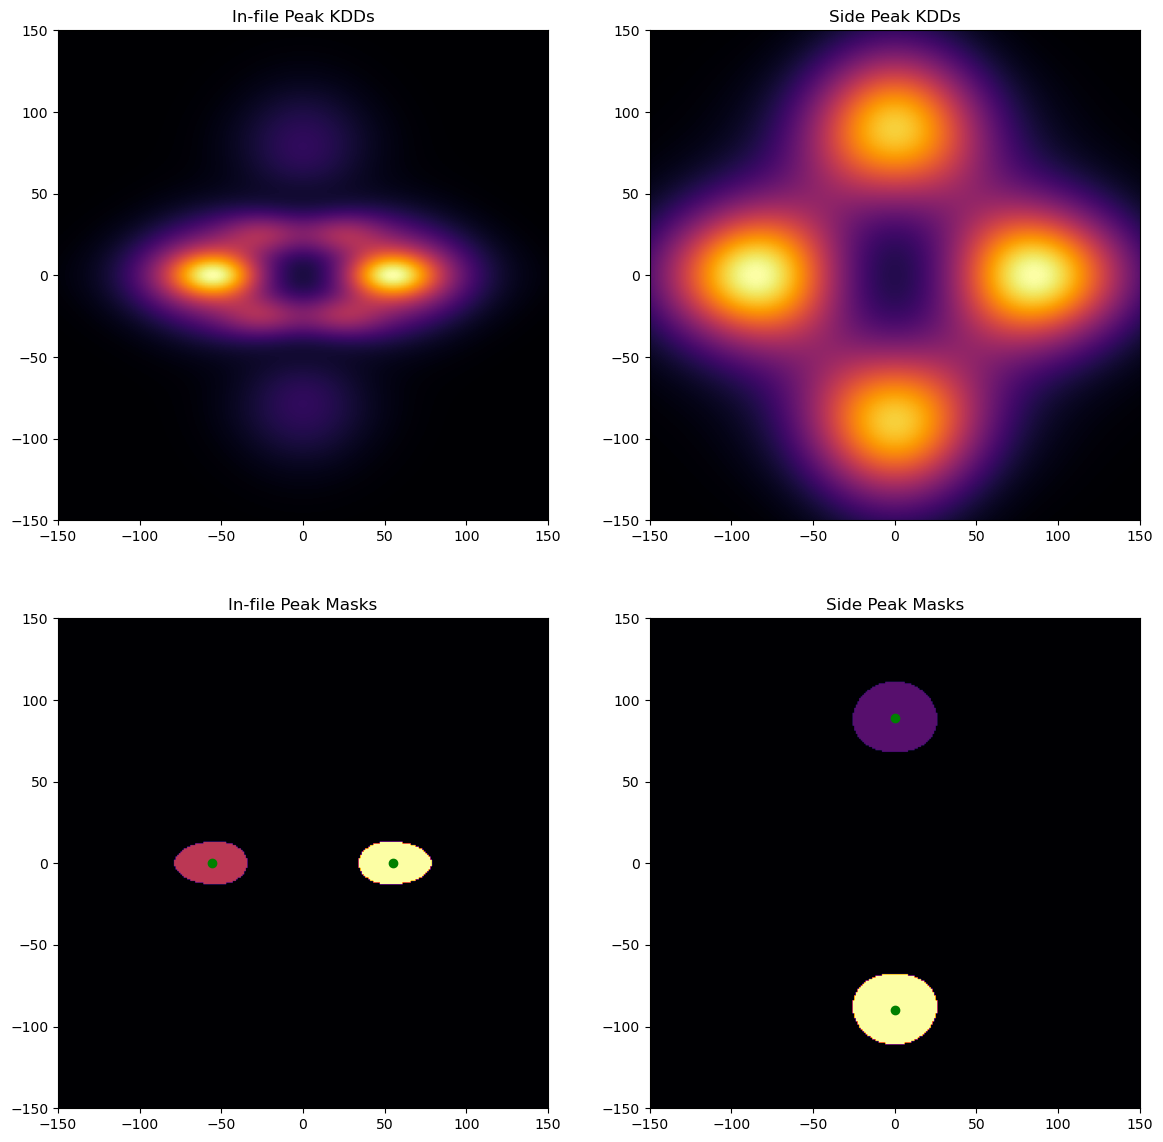

In [61]:
masking_val=0.6

cur_geno='Z019E0047'
fld=496
rep=1

trench_thresh=np.array(Tdist_series)[(geno_series=='Z019E0047') & (field_series==496) & (rep_series==1)][0]
buffer=SCW_mu/2

AccNNs=rankedNNs_2016[rankedNNs_2016['Genotype']==cur_geno]
RepNNs=AccNNs.iloc[np.where((AccNNs['Fieldplot']==fld) & (AccNNs['Replicate']==rep))[0],:]

RepZ1=np.array(Z1_series)[(geno_series=='Z019E0047') & (field_series==496) & (rep_series==1)][0]
RepZ2=np.array(Z2_series)[(geno_series=='Z019E0047') & (field_series==496) & (rep_series==1)][0]
RepZ3=np.array(Z3_series)[(geno_series=='Z019E0047') & (field_series==496) & (rep_series==1)][0]
RepZ4=np.array(Z4_series)[(geno_series=='Z019E0047') & (field_series==496) & (rep_series==1)][0]
RepZ5=np.array(Z5_series)[(geno_series=='Z019E0047') & (field_series==496) & (rep_series==1)][0]

RepZ1=RepZ1/np.max(RepZ1)
RepZ2=RepZ2/np.max(RepZ2)
RepZ3=RepZ3/np.max(RepZ3)
RepZ4=RepZ4/np.max(RepZ4)
RepZ5=RepZ5/np.max(RepZ5)

Zif=np.mean([RepZ1, RepZ2, RepZ3], axis=0)
Zif=SPP.stomata_KDD_rorshach(Zif)

Zsp=np.mean([RepZ4, RepZ5], axis=0)
Zsp=SPP.stomata_KDD_rorshach(Zsp)

SCL_mu=np.array(SClen_series)[np.where((geno_series=='Z019E0047') & (field_series==496) & (rep_series==1))[0]]
SCW_mu=np.array(SClen_series)[np.where((geno_series=='Z019E0047') & (field_series==496) & (rep_series==1))[0]]

if_len, if_wid, if_area, if_dist, sp_len, sp_wid, sp_area, sp_dist = SPP.stomata_KDD_peak_spacing(Zif, Zsp, xbound, ybound, masking_val, trench_thresh, buffer, True)


And above we can see the results of our masking operations on the in-file Z object (left column) as well as the side-file Z object (right column). The colors of the masks are randomly generated although the green points are designed to be consistent and represent the centroid positions of each mask they are sitting over. We can also see that the size and shape of these masks varies a bit even between ranks within the same replicate and this amount of spread or variance around these peaks was initially considered an important feature worth capturing.  Although the centroid distances were found by themselves to be sufficient given their strong correspondence to the mask variances this function and the capacity to generate these measures was retained with this library to allow for the option to generate these measures should they be useful. Now let's see how we might deploy these operations in a loop structure:

In [64]:
IFVlen_series=[]
IFVwid_series=[]
IFVarea_series=[]
IF_CDist_series=[]
SPVlen_series=[]
SPVwid_series=[]
SPVarea_series=[]
SP_CDist_series=[]

for cur_geno in genos: 
    
    flds=np.unique(rankedNNs_2016[rankedNNs_2016['Genotype']==cur_geno]['Fieldplot'])
    for fld in flds:
        
        reps=np.unique(rankedNNs_2016[(rankedNNs_2016['Genotype']==cur_geno) & (rankedNNs_2016['Fieldplot']==fld)]['Replicate'])   
        for rep in reps:
            
            print(cur_geno, fld, rep)
            
            RepZ1=np.array(Z1_series)[(geno_series==cur_geno) & (field_series==fld) & (rep_series==rep)][0]
            RepZ2=np.array(Z2_series)[(geno_series==cur_geno) & (field_series==fld) & (rep_series==rep)][0]
            RepZ3=np.array(Z3_series)[(geno_series==cur_geno) & (field_series==fld) & (rep_series==rep)][0]
            RepZ4=np.array(Z4_series)[(geno_series==cur_geno) & (field_series==fld) & (rep_series==rep)][0]
            RepZ5=np.array(Z5_series)[(geno_series==cur_geno) & (field_series==fld) & (rep_series==rep)][0]

            RepZ1=RepZ1/np.max(RepZ1)
            RepZ2=RepZ2/np.max(RepZ2)
            RepZ3=RepZ3/np.max(RepZ3)
            RepZ4=RepZ4/np.max(RepZ4)
            RepZ5=RepZ5/np.max(RepZ5)

            Zif=np.mean([RepZ1, RepZ2, RepZ3], axis=0)
            Zif=SPP.stomata_KDD_rorshach(Zif)

            Zsp=np.mean([RepZ4, RepZ5], axis=0)
            Zsp=SPP.stomata_KDD_rorshach(Zsp)

            SCL_mu=np.array(SClen_series)[np.where((geno_series==cur_geno) & (field_series==fld) & (rep_series==rep))[0]]
            SCW_mu=np.array(SClen_series)[np.where((geno_series==cur_geno) & (field_series==fld) & (rep_series==rep))[0]] 
            trench_thresh=np.array(Tdist_series)[(geno_series==cur_geno) & (field_series==fld) & (rep_series==rep)][0]
            buffer=SCW_mu/2
            
            if_len, if_wid, if_area, if_dist, sp_len, sp_wid, sp_area, sp_dist = SPP.stomata_KDD_peak_spacing(Zif, Zsp, xbound, ybound, masking_val, trench_thresh, buffer, False)
            
            IFVlen_series.append(if_len)
            IFVwid_series.append(if_wid)
            IFVarea_series.append(if_area)
            IF_CDist_series.append(if_dist)
            SPVlen_series.append(sp_len)
            SPVwid_series.append(sp_wid)
            SPVarea_series.append(sp_area)
            SP_CDist_series.append(sp_dist)


Z019E0047 496 1
Z019E0047 496 2
Z019E0047 496 3
Z019E0047 496 4
Z019E0052 501 2
Z019E0052 501 3
Z019E0052 501 4
Z019E0106 554 1
Z019E0106 554 2
Z019E0106 554 3
Z019E0106 554 4
Z019E0140 588 1
Z019E0140 588 2
Z019E0140 588 3
Z019E0140 588 4


And just like that we have successfully generated the last set of traits within this library! Moving first from converting our stomatal coordinate information into rank-ordered nearest neighbors to define the average packing within each image, we subsequently saw how to leverage the existing functions within this library to convert these rank-order NN relationships into a spatial probability surface describing our SPP, or stomatal patterning phenotype.  Finally we explore two of the main annotation functions which allow us to quickly extract spatial patterning information that can be used for downstream analysis.  Hopefully this tutorial was useful, this workflow and the methods around leveraging spatial approaches to address stomatal development and morphometrics is still actively being expanded upon so this framework may likely grow or refine over time.

For questions or comments feel free to reach out!

    -John Hodge 